# **Gaussian Mixture Model (GMM) and ELBO**

A **GMM** is a **latent variable model** with **discrete latent variables**:

- Latent variable:  
$$
z \in \{1,2,\dots,M\}
$$

- Marginal likelihood of data:  
$$
P_\theta(x) = \sum_z P_\theta(x, z)
$$

- Joint distribution factorization:  
$$
P_\theta(x,z) = P_\theta(z) \cdot P_\theta(x \mid z)
$$

---

### **Gaussian Mixture Model (GMM)**

In a GMM:

- Prior over latent variable $z$:  
$$
P_\theta(z = j) = \pi_j
$$

- Likelihood of data given component $j$:  
$$
P_\theta(x \mid z=j) = \mathcal{N}(x ; \mu_j, \Sigma_j)
$$

- Full marginal likelihood:  
$$
P_\theta(x) = \sum_{j=1}^{M} \pi_j \, \mathcal{N}(x ; \mu_j, \Sigma_j)
$$

---

### **Parameters of GMM**

We need to learn:

$$
\theta = \{\pi_1,\dots,\pi_M, \mu_1,\dots,\mu_M, \Sigma_1,\dots,\Sigma_M\}
$$

- $\pi_j \ge 0$ and $\sum_j \pi_j = 1$  
- $\mu_j \in \mathbb{R}^d$, $\Sigma_j \in \mathbb{R}^{d \times d}$

---

### **Expectation-Maximization (EM) Algorithm**

GMM parameters are estimated using **ELBO optimization** with the **EM algorithm**.

#### **E-Step (Expectation)**

Compute the **responsibility** (posterior of latent variable):  
$$
q_i^{(t)}(z=j) = P_\theta(z=j \mid x_i)
= \frac{\pi_j \, \mathcal{N}(x_i ; \mu_j, \Sigma_j)}
       {\sum_{k=1}^M \pi_k \, \mathcal{N}(x_i ; \mu_k, \Sigma_k)}
$$

This is also the **best $q(z|x)$** that optimizes the ELBO.

---

#### **M-Step (Maximization)**

Update parameters to maximize the **expected log-likelihood**:  
- Update mixture weights:  
$$
\pi_j^{(t+1)} = \frac{1}{N} \sum_{i=1}^N q_i^{(t)}(z=j)
$$

- Update means:  
$$
\mu_j^{(t+1)} = \frac{\sum_{i=1}^N q_i^{(t)}(z=j) \, x_i}{\sum_{i=1}^N q_i^{(t)}(z=j)}
$$

- Update covariances:  
$$
\Sigma_j^{(t+1)} =
\frac{\sum_{i=1}^N q_i^{(t)}(z=j) (x_i-\mu_j)(x_i-\mu_j)^\top}
     {\sum_{i=1}^N q_i^{(t)}(z=j)}
$$

---

### **EM Algorithm Summary for GMM**

1. Initialize $\pi_j, \mu_j, \Sigma_j$  
2. **E-step:** Compute $q(z|x)$ (responsibilities)  
3. **M-step:** Update $\pi_j, \mu_j, \Sigma_j$ using responsibilities  
4. Repeat until convergence  

---

### **Key Notes**

- EM **guarantees non-decreasing likelihood**:  
$$
\mathcal{L}(\theta^{(t+1)}) \ge \mathcal{L}(\theta^{(t)})
$$

- If $P_\theta(z \mid x)$ cannot be computed, **EM fails**  
- ELBO can still be used with **Variational Inference**


##  Generate Data for GMM

Step 1: Generated 20000 data points for 3 clusters


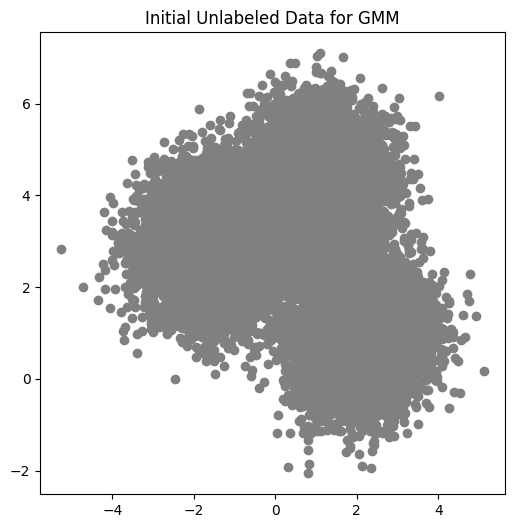

In [16]:
# ==============================
# Step 1: Generate 2D data for GMM
# ==============================
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

# Generate 2D data with 3 clusters
X, _ = make_blobs(n_samples=20000, centers=3, cluster_std=0.8, random_state=0)
X = jnp.array(X)

print("Step 1: Generated 20000 data points for 3 clusters")

# Visualize the raw data
plt.figure(figsize=(6,6))
plt.scatter(X[:,0], X[:,1], color='gray')
plt.title("Initial Unlabeled Data for GMM")
plt.show()


## Initialize GMM Parameters

In [12]:
# ==============================
# Step 2: Initialize GMM Parameters
# ==============================
key = jax.random.PRNGKey(42)
K = 3  # number of Gaussian components
N, D = X.shape

# Initialize mixture weights uniformly
pi = jnp.ones(K) / K
# Initialize means as random points
key, subkey = jax.random.split(key)
mu = X[jax.random.choice(subkey, N, shape=(K,), replace=False)]
# Initialize covariances as identity
Sigma = jnp.array([jnp.eye(D) for _ in range(K)])

print("Step 2: Initialized GMM parameters")
print("Initial Mixture Weights (pi):", pi)
print("Initial Means (mu):\n", mu)
print("Initial Covariances (Sigma):\n", Sigma)


Step 2: Initialized GMM parameters
Initial Mixture Weights (pi): [0.33333334 0.33333334 0.33333334]
Initial Means (mu):
 [[1.7261256  3.8511093 ]
 [2.652953   0.81262165]
 [1.3751938  3.8576374 ]]
Initial Covariances (Sigma):
 [[[1. 0.]
  [0. 1.]]

 [[1. 0.]
  [0. 1.]]

 [[1. 0.]
  [0. 1.]]]


## Define E-step and M-step Functions

In [13]:
# ==============================
# Step 3: Define E-step and M-step
# ==============================

def multivariate_gaussian(x, mean, cov):
    """Compute multivariate normal density for each x"""
    det = jnp.linalg.det(cov)
    inv = jnp.linalg.inv(cov)
    norm_const = 1.0 / jnp.sqrt((2*jnp.pi)**D * det)
    diff = x - mean
    return norm_const * jnp.exp(-0.5*jnp.sum(diff @ inv * diff, axis=1))

def e_step(X, pi, mu, Sigma):
    """Compute responsibilities gamma_ik = P(z=k|x_i)"""
    N = X.shape[0]
    K = pi.shape[0]
    gamma = []
    for k in range(K):
        gamma_k = pi[k] * multivariate_gaussian(X, mu[k], Sigma[k])
        gamma.append(gamma_k)
    gamma = jnp.stack(gamma, axis=1)
    gamma = gamma / jnp.sum(gamma, axis=1, keepdims=True)
    return gamma

def m_step(X, gamma):
    """Update pi, mu, Sigma"""
    N, D = X.shape
    K = gamma.shape[1]
    Nk = jnp.sum(gamma, axis=0)

    pi_new = Nk / N
    mu_new = (gamma.T @ X) / Nk[:, None]

    Sigma_new = []
    for k in range(K):
        diff = X - mu_new[k]
        cov_k = (gamma[:,k][:,None] * diff).T @ diff / Nk[k]
        Sigma_new.append(cov_k)
    Sigma_new = jnp.stack(Sigma_new, axis=0)
    return pi_new, mu_new, Sigma_new


# Run EM Algorithm and Visualize


===== Iteration 1 =====
E-step: First 5 responsibilities:
 [[4.6525842e-01 2.0139714e-01 3.3334440e-01]
 [3.3140206e-01 1.0595228e-02 6.5800279e-01]
 [2.3491850e-01 5.0192297e-04 7.6457959e-01]
 [2.4366200e-01 5.4943659e-03 7.5084364e-01]
 [1.8402925e-01 2.6740876e-05 8.1594408e-01]]
M-step: Updated mixture weights: [0.25372997 0.30132037 0.44494957]
M-step: Updated means:
 [[ 0.3275496   3.6519065 ]
 [ 2.0273974   0.8074369 ]
 [-0.44668347  3.453353  ]]


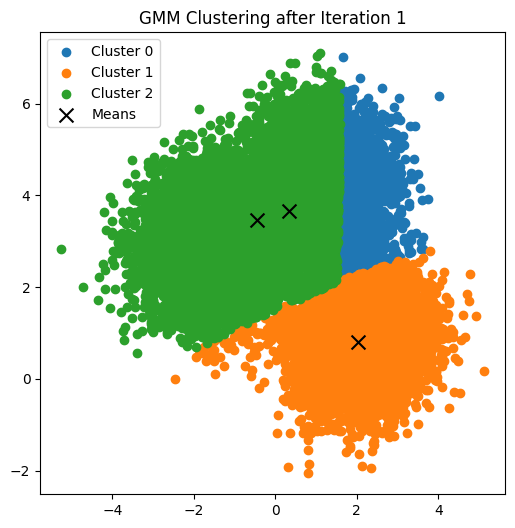


===== Iteration 2 =====
E-step: First 5 responsibilities:
 [[4.5101050e-01 3.0505788e-01 2.4393159e-01]
 [3.2884994e-01 1.3161474e-03 6.6983390e-01]
 [2.1571451e-01 1.2408281e-06 7.8428423e-01]
 [2.2129588e-01 4.3347329e-05 7.7866071e-01]
 [1.8726033e-01 1.9809832e-09 8.1273973e-01]]
M-step: Updated mixture weights: [0.24192408 0.31584725 0.44222867]
M-step: Updated means:
 [[ 0.27172807  3.7297573 ]
 [ 2.075851    0.84866095]
 [-0.5113497   3.4735022 ]]


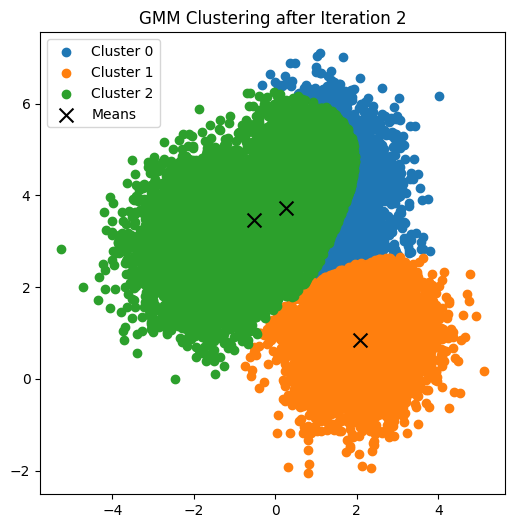


===== Iteration 3 =====
E-step: First 5 responsibilities:
 [[3.0924553e-01 5.7035816e-01 1.2039632e-01]
 [3.2683271e-01 3.0500523e-04 6.7286229e-01]
 [2.0273384e-01 2.7084592e-08 7.9726613e-01]
 [2.0826635e-01 1.4588546e-06 7.9173225e-01]
 [1.8835896e-01 7.6371262e-12 8.1164104e-01]]
M-step: Updated mixture weights: [0.23633863 0.32297876 0.44068256]
M-step: Updated means:
 [[ 0.25885302  3.7609367 ]
 [ 2.078914    0.8769535 ]
 [-0.5386447   3.4817593 ]]


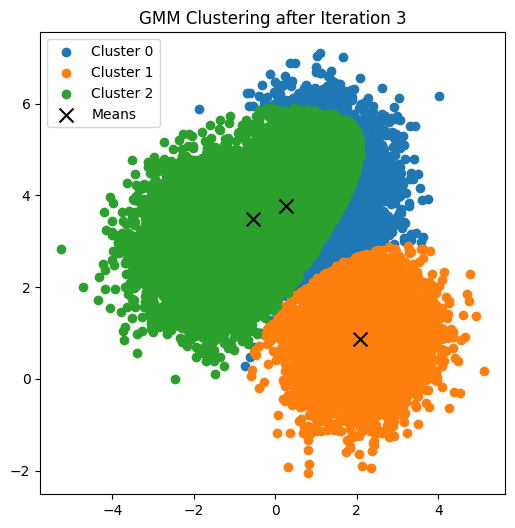


===== Iteration 4 =====
E-step: First 5 responsibilities:
 [[2.2090304e-01 7.0393741e-01 7.5159542e-02]
 [3.2708907e-01 3.3307745e-04 6.7257786e-01]
 [1.9485150e-01 2.4741555e-08 8.0514848e-01]
 [2.0287094e-01 1.1875685e-06 7.9712790e-01]
 [1.8120944e-01 7.4477863e-12 8.1879050e-01]]
M-step: Updated mixture weights: [0.23362722 0.32665792 0.43971485]
M-step: Updated means:
 [[ 0.26248482  3.777377  ]
 [ 2.0745578   0.89235836]
 [-0.55432475  3.4851031 ]]


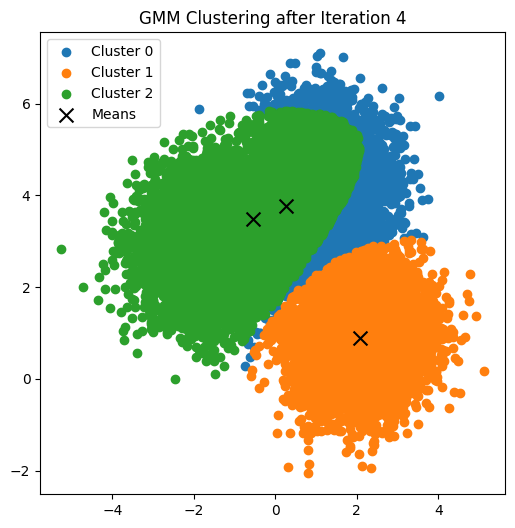


===== Iteration 5 =====
E-step: First 5 responsibilities:
 [[1.8276112e-01 7.5715435e-01 6.0084511e-02]
 [3.2770619e-01 4.2680386e-04 6.7186701e-01]
 [1.8921034e-01 3.6696093e-08 8.1078959e-01]
 [1.9994165e-01 1.5339939e-06 8.0005676e-01]
 [1.7135014e-01 1.4074275e-11 8.2864982e-01]]
M-step: Updated mixture weights: [0.23218237 0.32859224 0.4392254 ]
M-step: Updated means:
 [[ 0.27214798  3.788375  ]
 [ 2.0711434   0.9005638 ]
 [-0.56576526  3.4855337 ]]


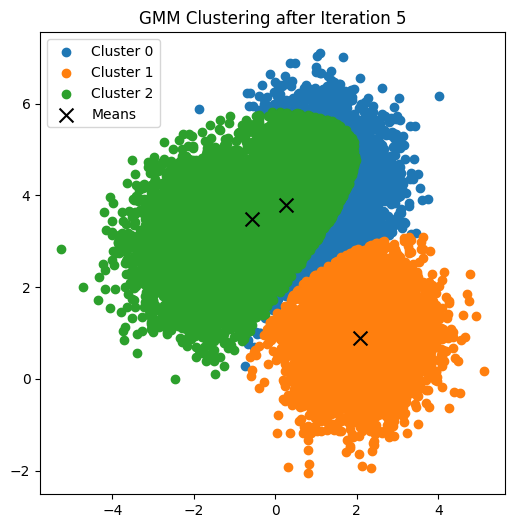

In [14]:
# ==============================
# Step 4: Run EM Algorithm with Visualization
# ==============================
import numpy as np

pi_est, mu_est, Sigma_est = pi, mu, Sigma
responsibility_history = []

for step in range(5):  # 5 iterations
    print(f"\n===== Iteration {step+1} =====")

    # E-step
    gamma = e_step(X, pi_est, mu_est, Sigma_est)
    responsibility_history.append(np.mean(gamma, axis=0))
    print("E-step: First 5 responsibilities:\n", gamma[:5])

    # M-step
    pi_est, mu_est, Sigma_est = m_step(X, gamma)
    print("M-step: Updated mixture weights:", pi_est)
    print("M-step: Updated means:\n", mu_est)

    # Visualize clustering
    labels = jnp.argmax(gamma, axis=1)
    plt.figure(figsize=(6,6))
    for k in range(K):
        plt.scatter(X[labels==k,0], X[labels==k,1], label=f"Cluster {k}")
    plt.scatter(mu_est[:,0], mu_est[:,1], color='black', marker='x', s=100, label='Means')
    plt.title(f"GMM Clustering after Iteration {step+1}")
    plt.legend()
    plt.show()


## Line Graph of Responsibility Evolution

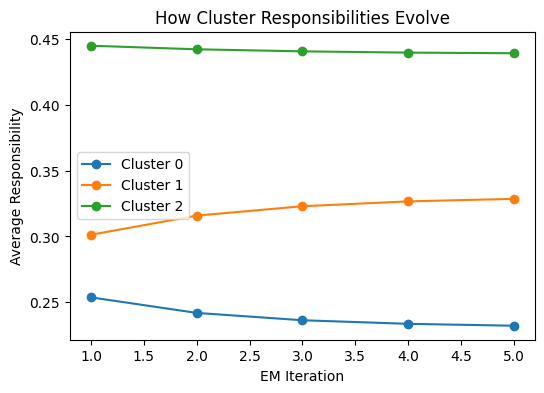

In [15]:
# ==============================
# Step 5: Visualize Responsibility Evolution
# ==============================
responsibility_history = np.array(responsibility_history)

plt.figure(figsize=(6,4))
for k in range(K):
    plt.plot(range(1, len(responsibility_history)+1),
             responsibility_history[:,k],
             marker='o', label=f"Cluster {k}")
plt.xlabel("EM Iteration")
plt.ylabel("Average Responsibility")
plt.title("How Cluster Responsibilities Evolve")
plt.legend()
plt.show()
